In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu
from smart_open import open
import pickle as pkl


import rdsutils.swap_set_analysis as ssa


%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

/home/ec2-user/anaconda3/envs/customer_risk/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load config and set local variables with config["mconfig"]
with open("../../config.json", "r") as f:
    config = json.load(f)
    
mconfig = config["monitoring_config"]  # monitoring config
rconfig = {}  # refitting config

locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

rconfig["artifact_path"] = artifact_path
rconfig["data_output_path"] = data_output_path


refitting_path = os.path.join(artifact_path, "refitting")
os.makedirs(refitting_path, exist_ok=True)

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [3]:
train_df = pd.read_parquet(modeling_df_path)
test_df = pd.read_parquet(test_df_path)

<AxesSubplot:>

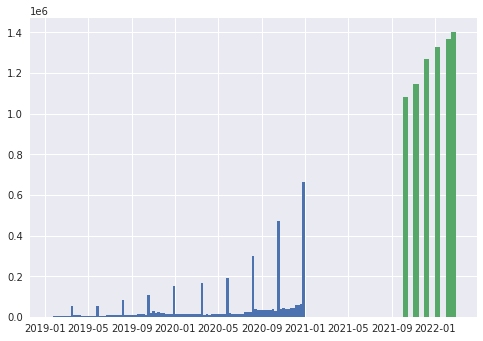

In [4]:
train_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=10)

In [5]:
# get fico baseline
# flip the sign to get positive corr with riskiness

def get_fico_adjusted_pred(df):
    
    df.loc[:, "fico_adjusted"] = (df["fico_score"] 
                                  * np.where(df["fico_score"] > 850, 0, 1))
    df.loc[:, "fico_adjusted_pred"] = -df["fico_adjusted"]
    
    return df

train_df = get_fico_adjusted_pred(train_df)
test_df = get_fico_adjusted_pred(test_df)

### Preprocess and get some stats
---

In [6]:
train_df = mu.preprocess(train_df)
test_df = mu.preprocess(test_df)

In [7]:
train_df.indeterminate.value_counts()

False    2061969
True     1729579
Name: indeterminate, dtype: int64

In [8]:
train_df.target.value_counts(normalize=True), test_df.target.value_counts(normalize=True)

(False    0.954515
 True     0.045485
 Name: target, dtype: float64,
 False    0.992989
 True     0.007011
 Name: target, dtype: float64)

In [9]:
train_df.indeterminate.value_counts(normalize=True), test_df.indeterminate.value_counts(normalize=True)

(False    0.543833
 True     0.456167
 Name: indeterminate, dtype: float64,
 True     0.892069
 False    0.107931
 Name: indeterminate, dtype: float64)

In [10]:
for d in test_df.sample_date.unique():
    print("===== date: ", d, " ======")
    print(test_df[test_df.sample_date==d][["target", "indeterminate"]].value_counts(normalize=True).sort_index())

===== date:  2021-10-01T00:00:00.000000000  ======
target  indeterminate
False   False            0.106410
        True             0.885377
True    False            0.004474
        True             0.003738
dtype: float64
===== date:  2021-11-01T00:00:00.000000000  ======
target  indeterminate
False   False            0.116521
        True             0.875264
True    False            0.004552
        True             0.003663
dtype: float64
===== date:  2021-12-01T00:00:00.000000000  ======
target  indeterminate
False   False            0.125610
        True             0.866110
True    False            0.004735
        True             0.003545
dtype: float64
===== date:  2022-01-01T00:00:00.000000000  ======
target  indeterminate
False   False            0.100162
        True             0.892430
True    False            0.004220
        True             0.003189
dtype: float64
===== date:  2022-02-01T00:00:00.000000000  ======
target  indeterminate
False   False            0.0974

### Fit Models
---

In our unfortunate naming: w_ind means with indeterminant that further translate to:
* We trained the model including the indeterminant data.

In [11]:
# without indeterminant
clf_wo_ind = refit.train(train_df,
                  date_col="sample_date",
                  indeterminate_col="indeterminate")

data statistics (3791548, 42)
indeterminate removed! column name:  indeterminate
data statistics after removing indeterminate (2061969, 42)
modeling_df last date: 2020-12-31 00:00:00
15556
target counts
False    1930031
True      131938
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[

In [12]:
clf_wo_ind

LGBMClassifier(bagging_seed=15556, boosting='gbdt',
               categorical_feature=[39, 40, 41], feature_fraction=0.8,
               lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
               metric='auc', min_data_in_leaf=116, num_iterations=1400,
               num_leaves=15, objective='binary',
               scale_pos_weight=14.628317846261123, seed=15556, subsample=0.94,
               tree_learner='feature', verbosity=1)

In [13]:
dt_str = train_df.sample_date.max().strftime('%Y-%m-%d')
refitted_model_path = os.path.join(data_output_path, f"refitted_model_{dt_str}.pkl")
rconfig["refitted_model_path"] = refitted_model_path

with open(refitted_model_path, "wb") as f:
    pkl.dump(clf_wo_ind, f)
    
with open(os.path.join(refitting_path, f"refitted_model_{dt_str}.pkl"), "wb") as f:
    pkl.dump(clf_wo_ind, f)
   

### Make Predictions, Scores, and RGs

In [14]:
# load models
models = {}
for mname, mpath in model_paths.items():
    with open(mpath, "rb") as f:
        models[mname] = pkl.load(f)
        
prev_model = models["incumbent_model"]

In [15]:
# let's scale by bads anyways
import rdsutils.score_alignment as sa

############################################
# the incumbent model and scaling method
############################################

test_df["pred_incumbent"] = prev_model.predict_proba(test_df[prev_model.feature_name_])[:,1]
test_df["score_incumbent"] = mu.scale_scores(test_df["pred_incumbent"])

#############################################
# prediction without indeterminates - dropped ind - rescaled
############################################

test_df["pred_wo_ind"] = clf_wo_ind.predict_proba(test_df[clf_wo_ind.feature_name_])[:,1]
test_df["score_wo_ind"] = mu.scale_scores(test_df["pred_wo_ind"])

In [16]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])


In [17]:
test_df['rg_incumbent'] = get_risk_groups(test_df.score_incumbent)
test_df['rg_wo_ind'] = get_risk_groups(test_df.score_wo_ind)

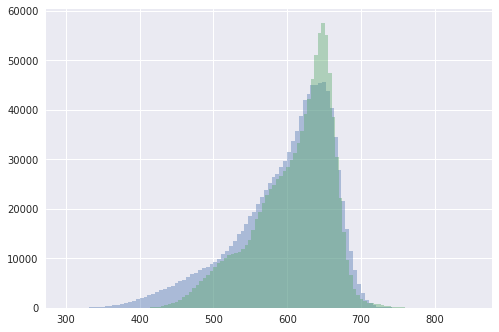

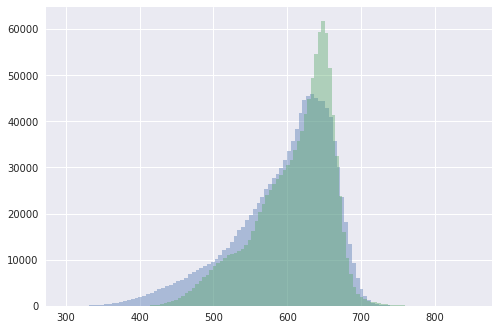

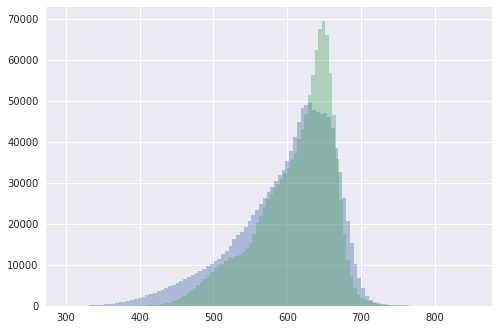

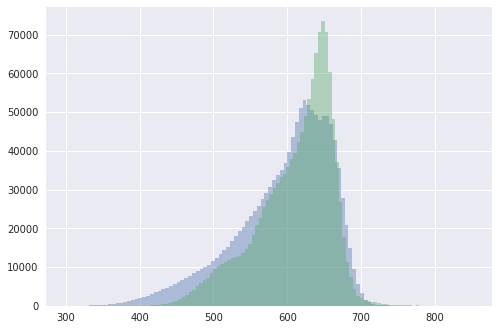

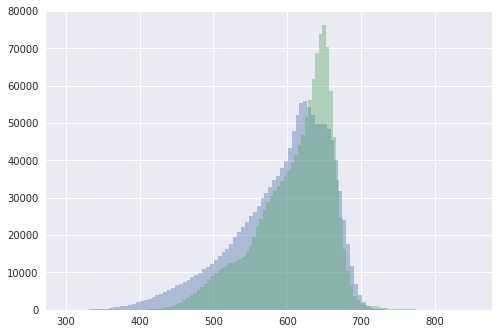

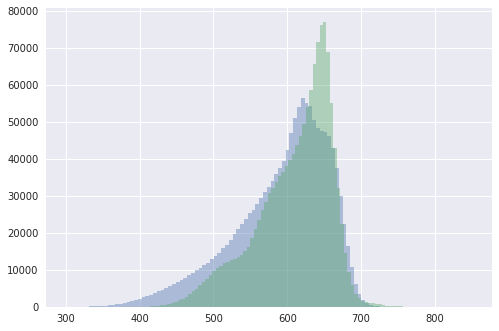

In [18]:
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff

for d in test_df.sample_date.unique():
    df_ = test_df[test_df.sample_date == d]
    for col in ["score_incumbent", "score_wo_ind"]:
        df_[col].hist(bins=100, alpha=0.4, label=col)
    plt.show()

In [19]:
test_df["is_active"] = (test_df.nr_past_transactions > 0) & (test_df.nr_transactions_30d > 0)

In [20]:
train_dt_str = train_df.sample_date.max().strftime('%Y-%m-%d')
mdf_path = os.path.join(data_output_path, f"modeling_df_{train_dt_str}_scored.parquet")
train_df.to_parquet(mdf_path)

tdf_path = os.path.join(data_output_path, f"test_df_{mmonth}_scored.parquet")
test_df.to_parquet(tdf_path)

rconfig["modeling_df_scored_path"] = mdf_path
rconfig["test_df_scored_path"] = tdf_path

In [21]:
cols = ["business_account_number", "sample_date", "borrower_id", 
        "pred_incumbent", "score_incumbent", "rg_incumbent", 
        "pred_wo_ind", "score_wo_ind", "rg_wo_ind"]

display(test_df[cols].shape)
display(test_df["sample_date"].unique())

dir_path = os.path.join(refitting_path, "to_business")
os.makedirs(dir_path, exist_ok=True)

for d in test_df["sample_date"].unique():
    dt_str = str(d).split("T")[0]
    fpath = os.path.join(dir_path, f"test_df_{dt_str}.csv")
    test_df[test_df["sample_date"] == d][cols].to_csv(fpath, index=False)

(7596720, 9)

array(['2021-10-01T00:00:00.000000000', '2021-11-01T00:00:00.000000000',
       '2021-12-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2022-02-01T00:00:00.000000000', '2022-03-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

### Performance
---

In [22]:
import src.monitoring.monitoring as mntr
import seaborn as sns

plt.style.use("seaborn")

def plot_score_distr(df, score1, score2, ax, title):
    df[score1].hist(bins=50, alpha=0.4, label=score1, ax=ax)

    df[score2].hist(bins=50, alpha=0.4, label=score2, ax=ax)
    
    ax.set_title(title)
    ax.legend()
    
    
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

  0%|          | 0/6 [00:00<?, ?it/s]

,auc,ap,ks
fico_adjusted_pred,64.08,1.19,23.62
fraud_score_2,60.78,1.25,15.84
score_incumbent,60.61,6.52,15.46
score_wo_ind,66.97,11.41,22.94


ratio of users kept their RG:  0.6938731041283307


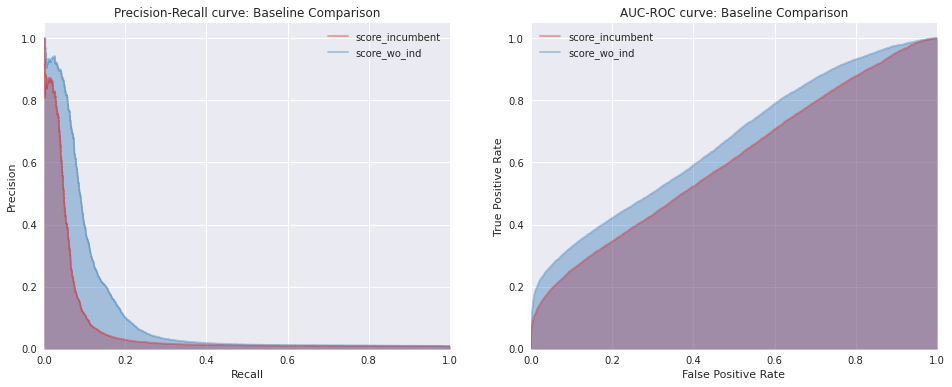

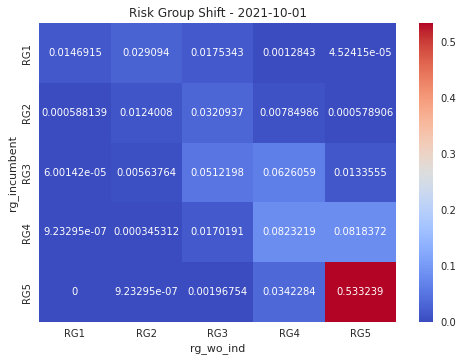

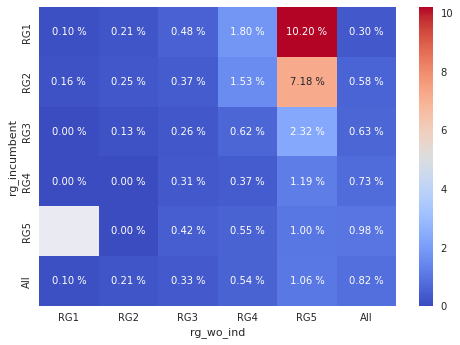

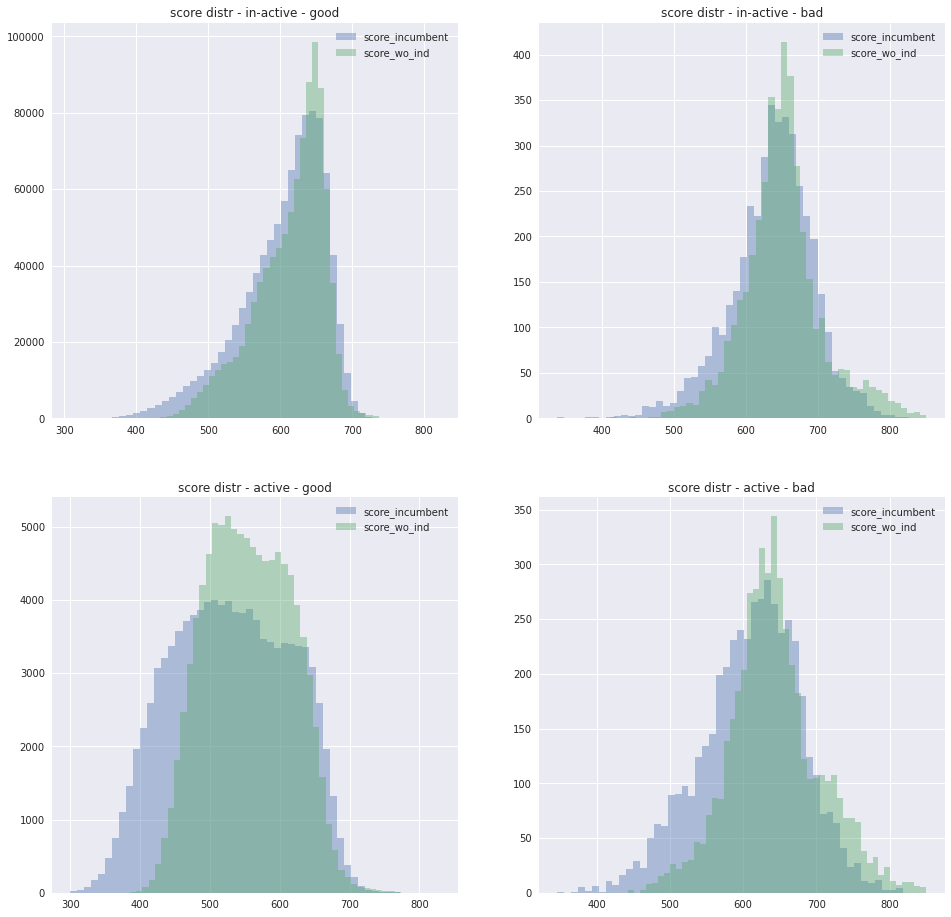

 17%|█▋        | 1/6 [00:57<04:47, 57.59s/it]

,auc,ap,ks
fico_adjusted_pred,62.99,1.15,22.15
fraud_score_2,60.96,1.26,16.10
score_incumbent,60.31,5.48,14.07
score_wo_ind,65.67,10.90,20.55


ratio of users kept their RG:  0.677998339326338


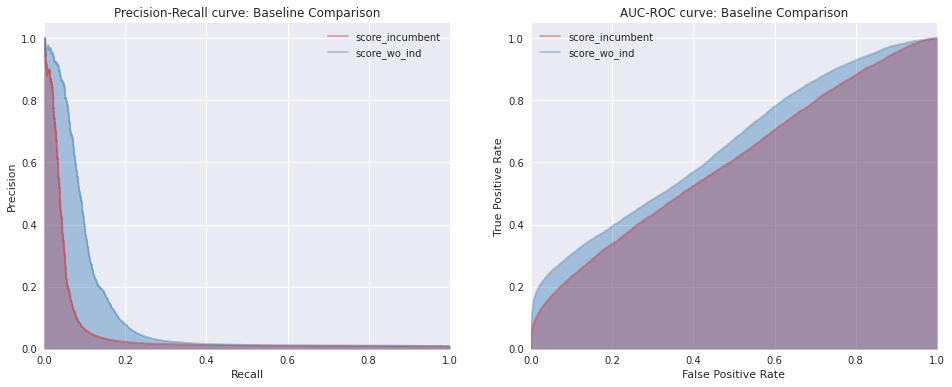

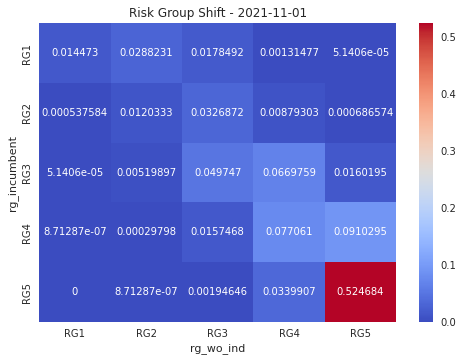

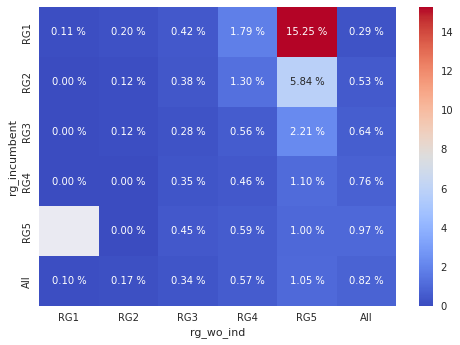

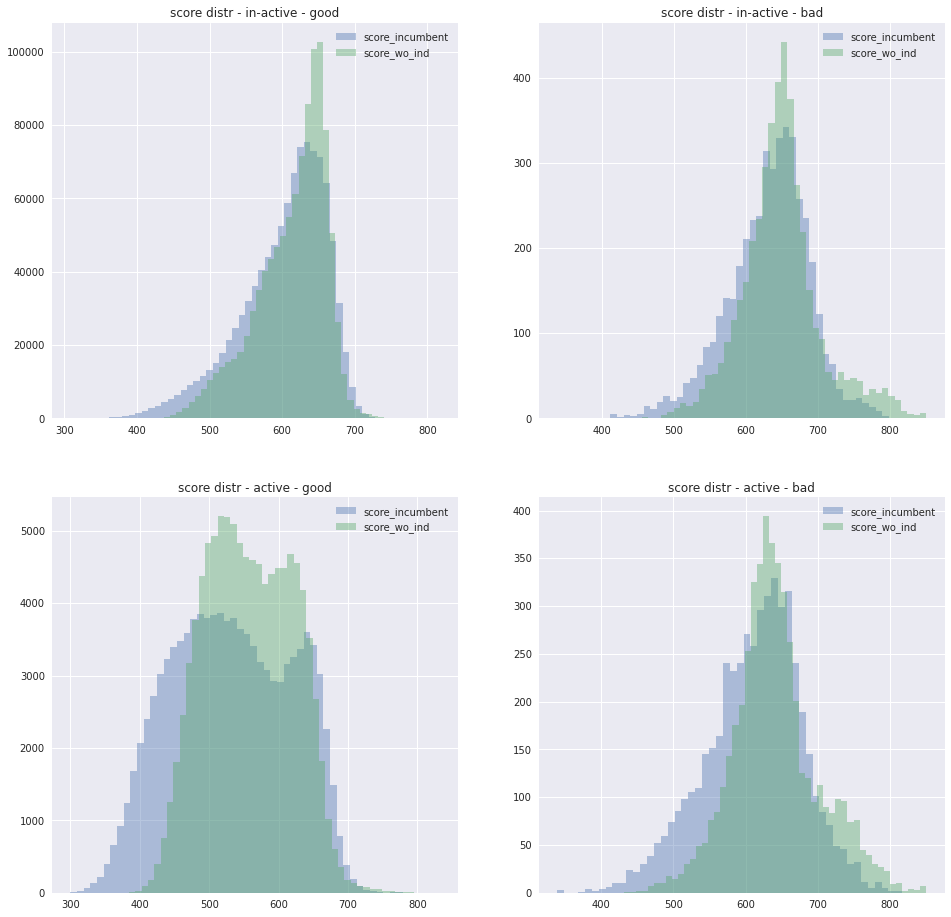

 33%|███▎      | 2/6 [01:58<03:59, 59.82s/it]

,auc,ap,ks
fico_adjusted_pred,61.27,1.10,19.65
fraud_score_2,62.93,1.48,19.06
score_incumbent,60.83,5.09,14.83
score_wo_ind,66.60,11.55,23.40


ratio of users kept their RG:  0.6756895538750636


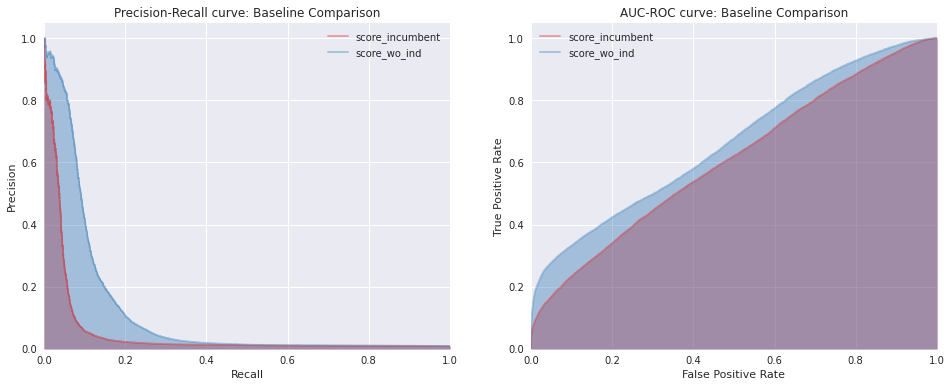

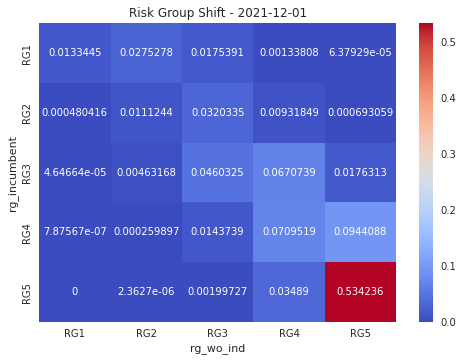

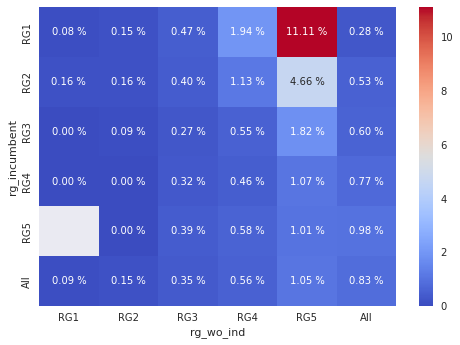

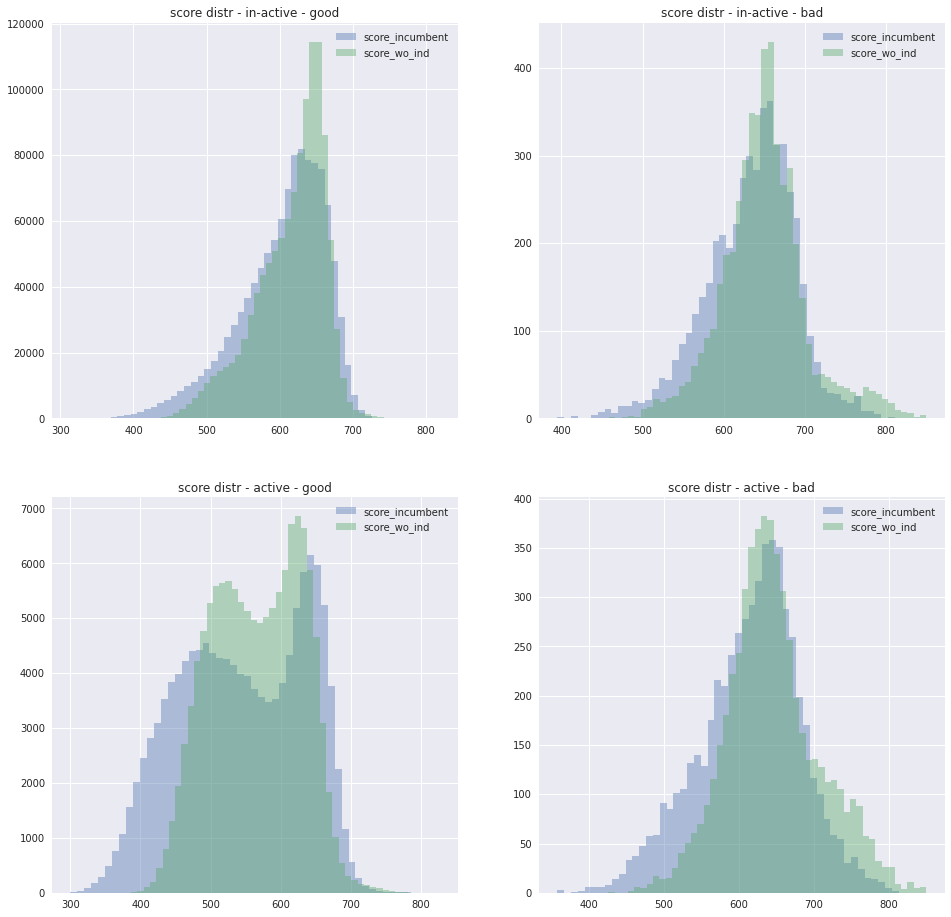

 50%|█████     | 3/6 [03:07<03:11, 63.70s/it]

,auc,ap,ks
fico_adjusted_pred,61.33,0.99,19.73
fraud_score_2,61.42,1.17,17.02
score_incumbent,61.30,8.07,15.50
score_wo_ind,66.88,16.61,26.07


ratio of users kept their RG:  0.6567676237926665


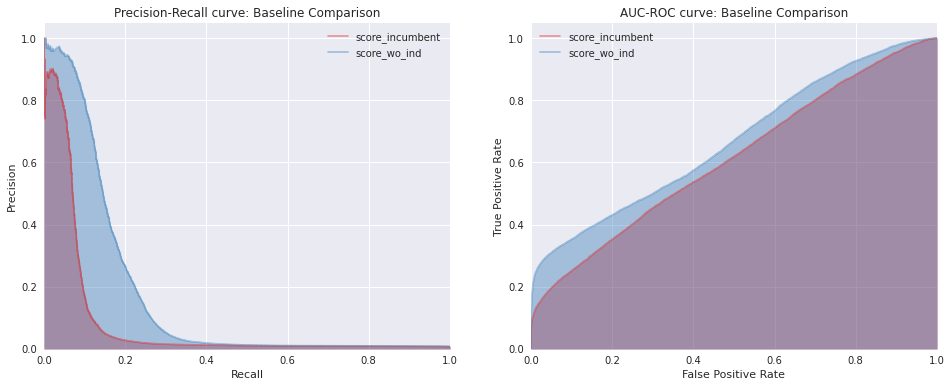

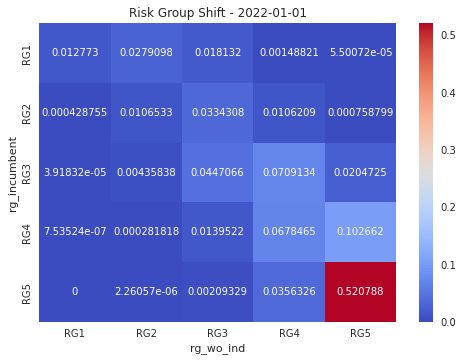

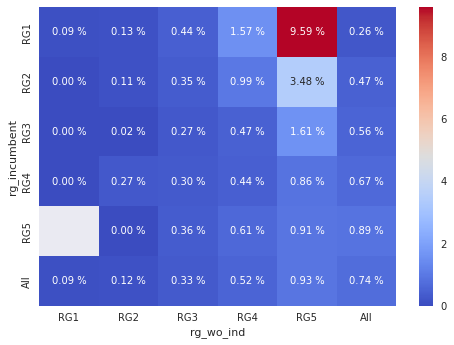

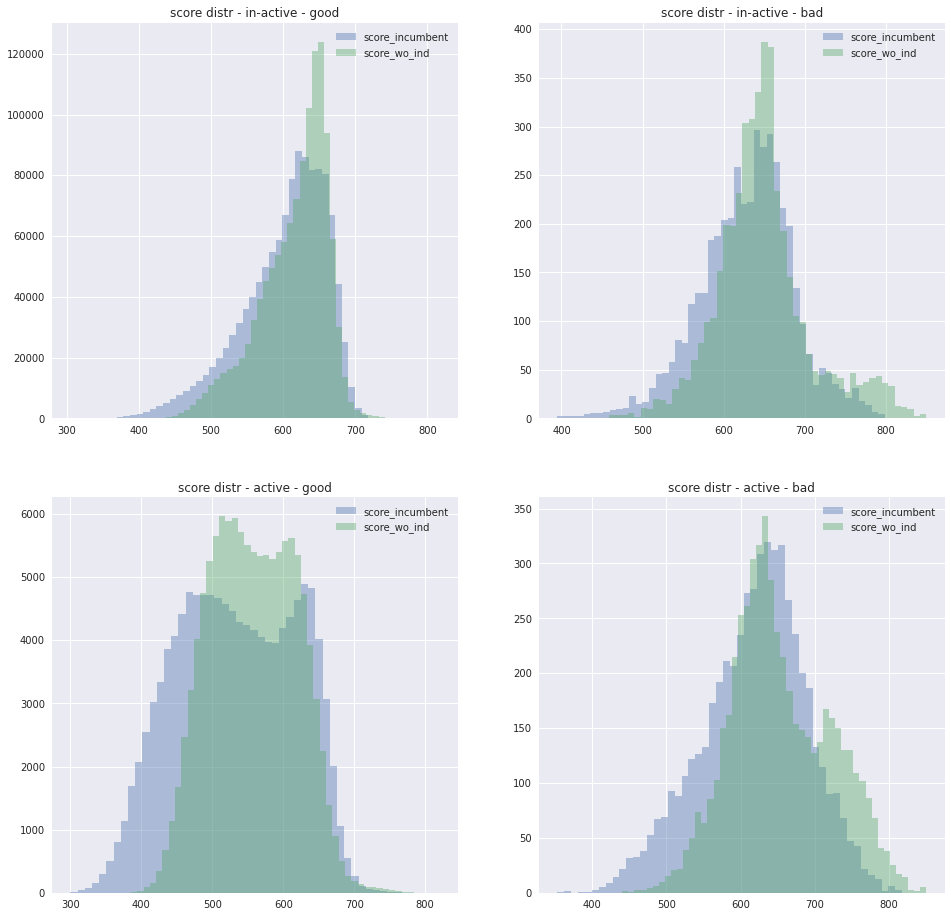

 67%|██████▋   | 4/6 [04:18<02:13, 66.62s/it]

,auc,ap,ks
fico_adjusted_pred,60.30,0.81,17.87
fraud_score_2,61.63,1.01,17.57
score_incumbent,61.80,9.20,16.79
score_wo_ind,67.22,18.45,27.89


ratio of users kept their RG:  0.6417327268472475


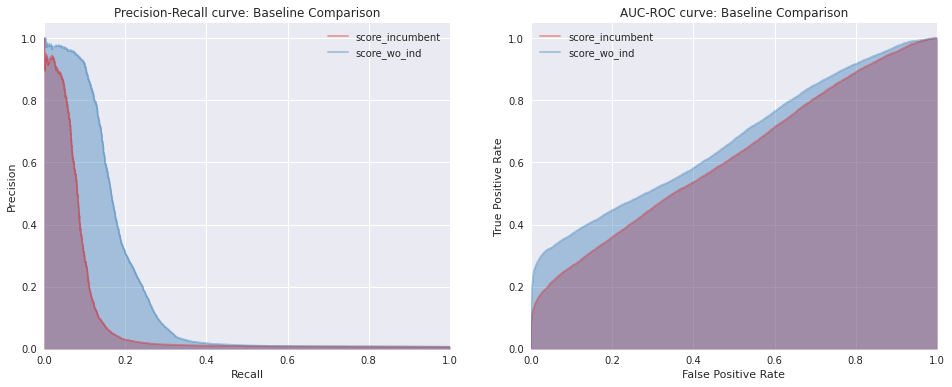

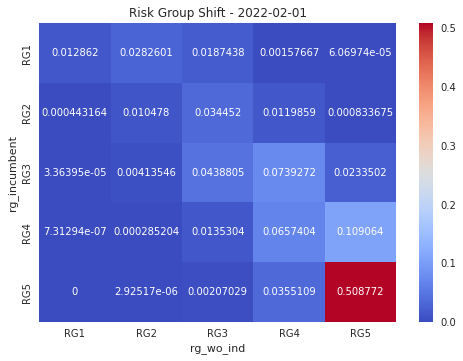

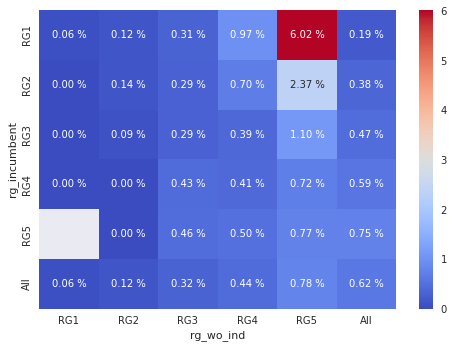

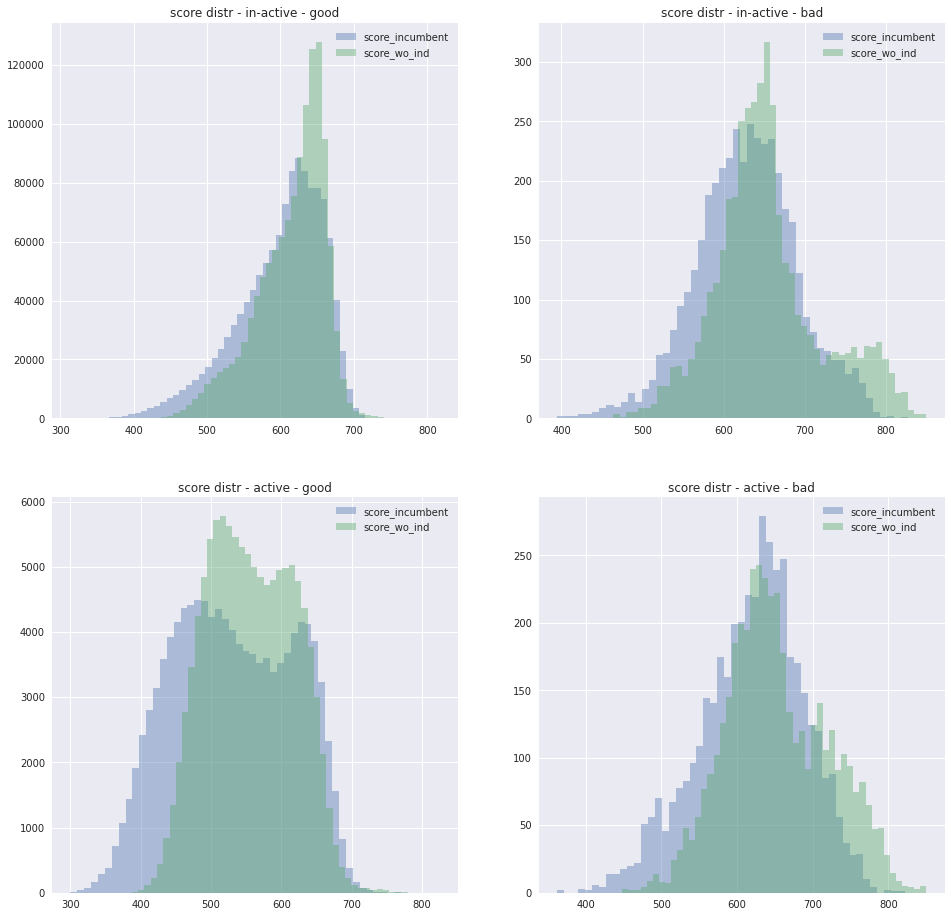

 83%|████████▎ | 5/6 [05:32<01:09, 69.16s/it]

,auc,ap,ks
fico_adjusted_pred,58.87,0.54,15.23
fraud_score_2,62.98,0.80,19.48
score_incumbent,60.78,9.07,16.37
score_wo_ind,67.10,18.36,29.10


ratio of users kept their RG:  0.6261534949094256


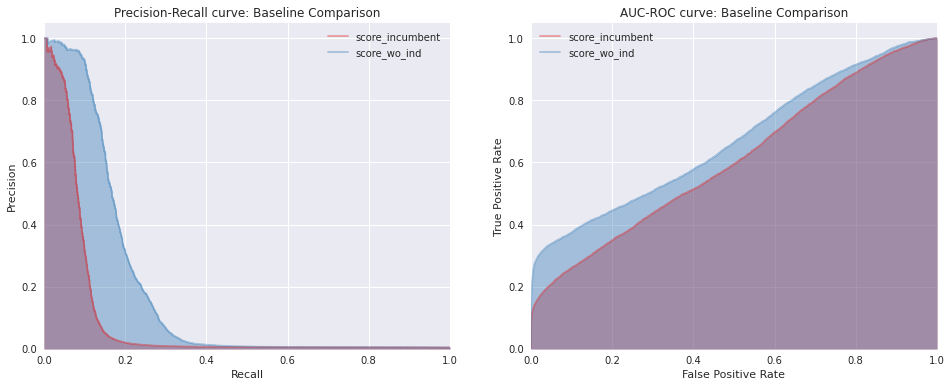

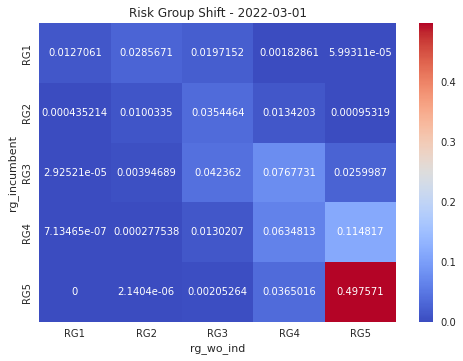

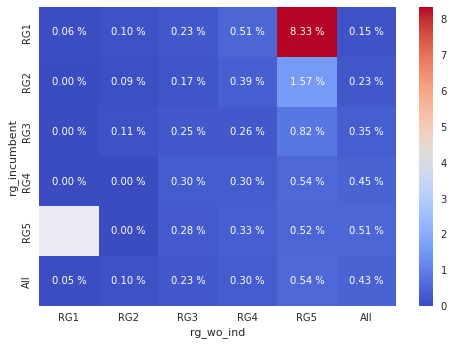

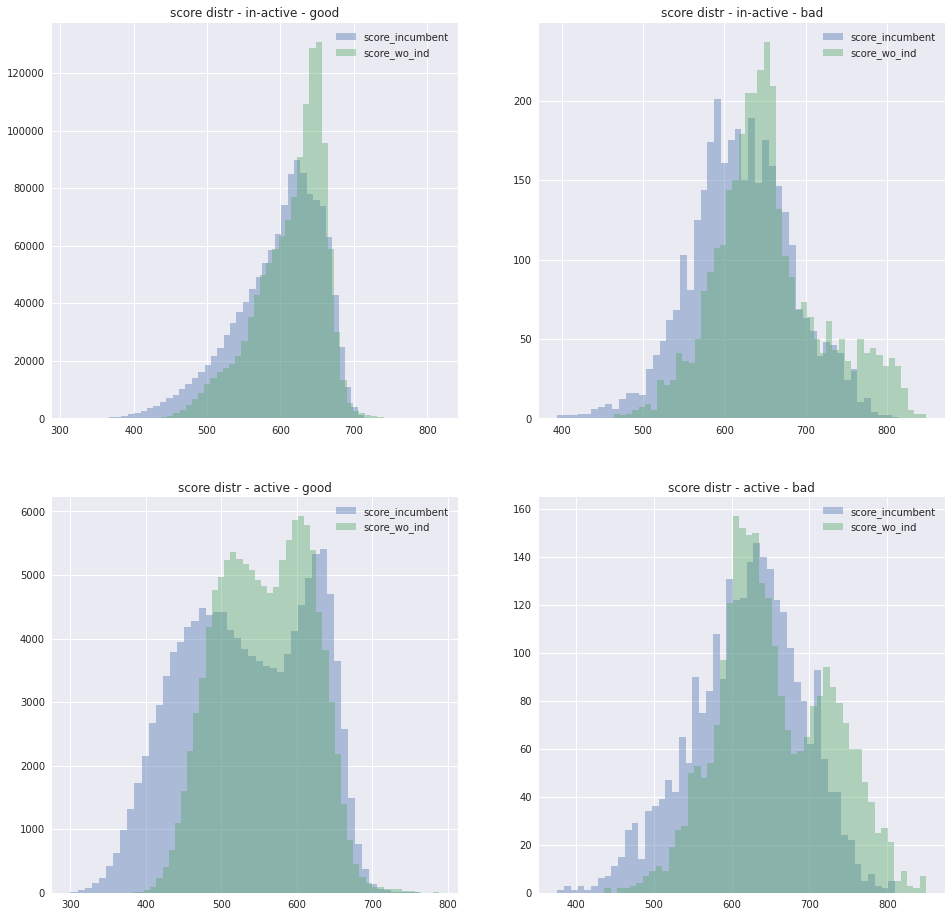

100%|██████████| 6/6 [06:47<00:00, 67.88s/it]


In [23]:
for dt_str in tqdm(monitoring_dates):

    pred_cols = ['fico_adjusted_pred',
                 'fraud_score_2',
                 "score_incumbent", 
                 "score_wo_ind"]
    df_ = test_df[test_df.sample_date == pd.to_datetime(dt_str)]

    # get monitoring metric reports
    report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
    display(report)

    # plot performance plots for only refitted vs incumbent
    pred_cols = ["score_incumbent", 
                 "score_wo_ind"]

    mntr_path = os.path.join(refitting_path, dt_str) #  "./artifacts/refitting"
    mntr.save_valid_performance_plots(
            {dt_str: df_}, "target", pred_cols, mntr_path, dropna=False
        )

    # model prediction
    mntr.get_segmented_performances(
        {dt_str: df_},
        "target",
        ["score_wo_ind"],
        os.path.join(mntr_path, dt_str),
        model_name="customer_risk",
    )

    # on vs fico adjusted - only valid fico
    mntr.get_model_vs_baseline(
        df_,
        "target",
        "score_wo_ind",
        "score_incumbent",
        os.path.join(mntr_path, dt_str),
    )


    # look at risk groups
    rg_incumbent = "rg_incumbent"
    rg_refit = "rg_wo_ind"
    table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
    table.columns = [rg_incumbent, rg_refit, 'counts']
    table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                           columns=rg_refit, fill_value=0)
    fig = plt.figure()
    sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
    plt.title(f'Risk Group Shift - {dt_str}')

    fig.savefig(os.path.join(mntr_path, f"rg_shift_{dt_str}.png"))
    print("ratio of users kept their RG: ", np.trace(table))

    # swap set statistics
    fig, ax = ssa.plot_swap_set_bad_rate(df_, rg_incumbent, rg_refit, "target", margins=True)
    fig.savefig(os.path.join(mntr_path, f"bad_rate-{dt_str}.png"))

    # active & badness segmentations
    # plot 4x4
    score1 = "score_incumbent"
    score2 = "score_wo_ind"

    fig, axs = plt.subplots(2,2, figsize=(16, 16))

    df_ = test_df[test_df.sample_date == pd.to_datetime(dt_str)]

    df__ = df_[~df_.is_active & ~df_.target]  # inactive good accounts
    plot_score_distr(df__, score1, score2, axs[0, 0], "score distr - in-active - good")

    df__ = df_[~df_.is_active & df_.target]  # inactive bad accounts
    plot_score_distr(df__, score1, score2, axs[0, 1], "score distr - in-active - bad")

    df__ = df_[df_.is_active & ~df_.target]  # active good accounts
    plot_score_distr(df__, score1, score2, axs[1, 0], "score distr - active - good")

    df__ = df_[df_.is_active & df_.target]  # active bad accounts
    plot_score_distr(df__, score1, score2, axs[1, 1], "score distr - active - bad")

    plt.show()
    fig.savefig(os.path.join(mntr_path, f"{dt_str}_activeness.png"))

### Save Updated config

In [24]:
config["refitting_config"] = rconfig

with open("../../config.json", "w") as f:
    json.dump(config, f, indent=4)